### If the articles are assigned randomly to clusters, what's the probability of finding a DAMOP sessions with a majority of talks in one cluster?
This is to benchmark a null hypothesis against our findings.

In [1]:
%matplotlib inline
import numpy as np
import sympy
from matplotlib import pyplot as plt
import itertools
from collections import Counter
import math
import random
import json

In [35]:
def majority(m_abstracts, k_clusters):
    prob = 0
    for n in range(int(math.ceil(m_abstracts/2.)), m_abstracts+1):
        prob += exactly_n_sessions(m_abstracts, k_clusters, n)
    return prob

def exactly_n_sessions(m_abstracts, k_clusters, n):
    '''This only works if n is equal to or more than half.'''
#     p = (1./k_clusters)**(n) * (1 - 1./k_clusters)**(m_abstracts - n)
    
    if 2*n == m_abstracts:
        # Subtract the overcounted combiantions, e.g. [1, 1, 1, 2, 2, 2]
        return sympy.binomial(m_abstracts, n) *  \
                   ( k_clusters * (k_clusters - 1)**(m_abstracts - n) - \
                     k_clusters * (k_clusters - 1) / 2 )
        
    elif 2*n > m_abstracts:
        return sympy.binomial(m_abstracts, n) * k_clusters * (k_clusters - 1)**(m_abstracts - n)
    else:
        raise ValueError("Not yet implemented!")

def one_cluster_majority(session_list):
    count = Counter(session_list)
#     return 2*count.most_common()[0][1] >= len(session_list)
    return (2*count.most_common()[0][1] >= len(session_list), count.most_common()[0][1])

def two_cluster_majority(session_list):
    count = Counter(session_list)
    if len(count.most_common(2)) > 1:
        num = count.most_common(2)[0][1] + count.most_common(2)[1][1]
    else:
        num = count.most_common(2)[0][1]
        
    return (2*num >= len(session_list), num)

In [3]:
k = 8
m = 6

# all_permutations is a function that returns an iterator. This is to save on memory.
all_permutations = lambda: itertools.product(range(k), repeat=m)
# print len(all_permutations)
print sum(1 for _ in all_permutations())
print k**m

262144
262144


In [4]:
count = Counter( (one_cluster_majority(x)[1] for x in all_permutations() ) )
# print count
print {n: exactly_n_sessions(m, k, n) for n in range(int(math.ceil(m/2.)), m+1)}
print {n: count[n] for n in range(int(math.ceil(m/2.)), m+1)}
print majority(m, k)
print sum(1 for x in all_permutations() if one_cluster_majority(x)[0] )

{3: 54320, 4: 5880, 5: 336, 6: 8}
{3: 54320, 4: 5880, 5: 336, 6: 8}
60544
60544


In [5]:
# For large k, can't count all the combiations. Instead, we generate random data.
k = 20
m = 7
samples = int(1e6)

random_permutations = lambda: ( [random.randint(0, k-1) for x in range(m)] for y in range(samples) )

count = Counter( (one_cluster_majority(x)[1] for x in random_permutations() ) )

print {n: float(exactly_n_sessions(m, k, n))/(k**m) for n in range(int(math.ceil(m/2.)), m+1)}
print {n: float(count[n])/samples for n in range(int(math.ceil(m/2.)), m+1)}
print float(majority(m, k))/(k**m)
print sum([ float(count[n])/samples for n in range(int(math.ceil(m/2.)), m+1) ])

{4: 0.003751015625, 5: 0.000118453125, 6: 2.078125e-06, 7: 1.5625e-08}
{4: 0.003766, 5: 0.000108, 6: 4e-06, 7: 0.0}
0.0038715625
0.003878


#### Make a model from the DAMOP sessions

In [6]:
with open('../../damop data/damop2016.json') as f:
    damop = json.load(f)

In [7]:
damop_session_len = [ len(x['abstracts']) for x in damop
                      if (len(x['abstracts']) > 5) and (len(x['abstracts']) < 40) ]
print damop_session_len

[9, 7, 10, 10, 7, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 7, 10, 7, 10, 10, 10, 10, 10, 9, 7, 6, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 6, 10, 10, 10, 9, 10, 10, 9, 10, 9, 10, 10, 7, 8, 9]


In [8]:
# For each session, calculate the probability that each sessions is covered mostly by one cluster
damop_session_prob = lambda k: [ float(majority(m, k))/(k**m) for m in damop_session_len]

In [31]:
two_cluster_majority(generate_damop_clusters(10)[0])

[(1, 2), (3, 2)]
2
2


(False, 4)

In [40]:
# Randomly assign clusters to each session and count
k = range(1, 60)
prob_one = []
prob_two = []
samples = int(1e3)
generate_damop_clusters = lambda k: [ [random.randint(0, k-1) for x in range(x)] for x in damop_session_len ]
# print generate_damop_clusters(10)

for k0 in k:
    prob_one.append(np.mean([float(sum([one_cluster_majority(x)[0] for x in generate_damop_clusters(k0)]))/len(damop_session_len)
                 for _ in range(samples)]))
    prob_two.append(np.mean([float(sum([two_cluster_majority(x)[0] for x in generate_damop_clusters(k0)]))/len(damop_session_len)
                 for _ in range(samples)]))

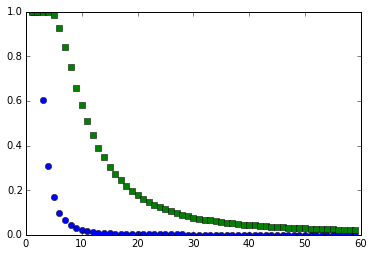

In [41]:
plt.plot(k, prob_one, 'o',
         k, prob_two, 's')

with open("cluster-random.json", "w") as f:
    json.dump({'k': k,
               'prob_one': prob_one,
               'prob_two': prob_two}, f)

In [ ]:
#Exact estimate: this is a royal pain. Will do later (or not at all)

In [ ]:
# # Better estimate: sum over all the possibilities
# # n_exactly = 6
# k = 6
# current_damop_session_prob = damop_session_prob(k)

# data = {n: 0. for n in range(len(current_damop_session_prob)+1)}

# for combo in itertools.product([True, False], repeat=len(current_damop_session_prob)):
#     print combo
#     current_prob = 1.
#     sessions_majority = 0
#     for x, y in zip(combo, current_damop_session_prob):
#         if x == True:
#             current_prob *= y
#             sessions_majority += 1
#         else:
#             current_prob *= 1.-y
# #     print (sessions_majority, current_prob)
#     data[sessions_majority] += current_prob

# # for n_exactly in range(len(damop_session_len)):
    
# print data
# # damop_session_prob(3)